In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exploring-predictive-health-factors/sample_submission.csv
/kaggle/input/exploring-predictive-health-factors/train.csv
/kaggle/input/exploring-predictive-health-factors/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
train = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/train.csv')
train.head()

,ID,Age,Weight_kg,PCOS,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,0,20-25,64.0,No,No,No,No,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,Somewhat
1,1,15-20,55.0,No,No,No,No,No,No,6-8 Times a Week,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
2,2,15-20,91.0,No,No,No,Yes,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Somewhat
3,3,15-20,56.0,No,No,No,No,No,No,6-8 Times a Week,"Cardio (e.g., running, cycling, swimming)",45 minutes,6-8 hours,Not at All
4,4,15-20,47.0,No,Yes,No,No,No,No,Rarely,No Exercise,Not Applicable,6-8 hours,Not Much


In [4]:
test = pd.read_csv('/kaggle/input/exploring-predictive-health-factors/test.csv')
test.head()

,ID,Age,Weight_kg,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,0,20-25,54.0,No,No,No,No,No,Rarely,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
1,1,20-25,65.0,Yes,No,No,No,No,3-4 Times a Week,No Exercise,Not Applicable,6-8 hours,Somewhat
2,2,20-25,64.0,Yes,No,No,No,No,6-8 Times a Week,Cardio (e.g.,Not Applicable,6-8 hours,Somewhat
3,3,Less than 20,57.0,Yes,No,Yes,No,Yes,Rarely,No Exercise,6-8 hours,6-8 hours,Somewhat
4,4,Less than 20,6.0,Yes,No,Yes,No,No,Rarely,Cardio (e.g.,30 minutes,6-8 hours,Somewhat


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     210 non-null    int64  
 1   Age                    209 non-null    object 
 2   Weight_kg              208 non-null    float64
 3   PCOS                   210 non-null    object 
 4   Hormonal_Imbalance     208 non-null    object 
 5   Hyperandrogenism       207 non-null    object 
 6   Hirsutism              205 non-null    object 
 7   Conception_Difficulty  209 non-null    object 
 8   Insulin_Resistance     209 non-null    object 
 9   Exercise_Frequency     208 non-null    object 
 10  Exercise_Type          208 non-null    object 
 11  Exercise_Duration      208 non-null    object 
 12  Sleep_Hours            208 non-null    object 
 13  Exercise_Benefit       209 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 23.1+ KB

In [6]:
train.shape

(210, 14)

In [7]:
train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,210.0,NaN,NaN,NaN,104.5,60.765944,0.0,52.25,104.5,156.75,209.0
Age,209,10,20-25,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight_kg,208.0,NaN,NaN,NaN,56.159615,12.572768,20.0,48.0,55.0,64.0,116.0
PCOS,210,2,No,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hormonal_Imbalance,208,4,Yes,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hyperandrogenism,207,2,No,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hirsutism,205,3,No,148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Conception_Difficulty,209,4,No,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Insulin_Resistance,209,3,No,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exercise_Frequency,208,8,Rarely,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.duplicated().sum()

0

In [9]:
df = train.copy()

In [10]:
print(df['Age'].value_counts())
print(df['PCOS'].value_counts())
print(df['Hormonal_Imbalance'].value_counts())
print(df['Hyperandrogenism'].value_counts())
print(df['Hirsutism'].value_counts())
print(df['Conception_Difficulty'].value_counts())
print(df['Insulin_Resistance'].value_counts())
print(df['Exercise_Frequency'].value_counts())
print(df['Exercise_Type'].value_counts())
print(df['Exercise_Duration'].value_counts())
print(df['Sleep_Hours'].value_counts())
print(df['Exercise_Benefit'].value_counts())

Age
20-25              125
15-20               50
Less than 20        18
35-44                4
25-30                4
45 and above         3
30-35                2
30-25                1
30-40                1
Less than 20-25      1
Name: count, dtype: int64
PCOS
No     164
Yes     46
Name: count, dtype: int64
Hormonal_Imbalance
Yes                                   111
No                                     95
No, Yes, not diagnosed by a doctor      1
Yes Significantly                       1
Name: count, dtype: int64
Hyperandrogenism
No     175
Yes     32
Name: count, dtype: int64
Hirsutism
No                                    148
Yes                                    55
No, Yes, not diagnosed by a doctor      2
Name: count, dtype: int64
Conception_Difficulty
No                                    201
Yes, diagnosed by a doctor              6
No, Yes, not diagnosed by a doctor      1
Yes                                     1
Name: count, dtype: int64
Insulin_Resistance
No          

In [11]:
df.isnull().sum()

ID                       0
Age                      1
Weight_kg                2
PCOS                     0
Hormonal_Imbalance       2
Hyperandrogenism         3
Hirsutism                5
Conception_Difficulty    1
Insulin_Resistance       1
Exercise_Frequency       2
Exercise_Type            2
Exercise_Duration        2
Sleep_Hours              2
Exercise_Benefit         1
dtype: int64

In [12]:
def countplots(data, feature,perc):
  ax = sns.countplot(data = df, x = feature)
  plt.xticks(rotation = 90)
  for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / len(data[feature])
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
  plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     210 non-null    int64  
 1   Age                    209 non-null    object 
 2   Weight_kg              208 non-null    float64
 3   PCOS                   210 non-null    object 
 4   Hormonal_Imbalance     208 non-null    object 
 5   Hyperandrogenism       207 non-null    object 
 6   Hirsutism              205 non-null    object 
 7   Conception_Difficulty  209 non-null    object 
 8   Insulin_Resistance     209 non-null    object 
 9   Exercise_Frequency     208 non-null    object 
 10  Exercise_Type          208 non-null    object 
 11  Exercise_Duration      208 non-null    object 
 12  Sleep_Hours            208 non-null    object 
 13  Exercise_Benefit       209 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 23.1+ KB

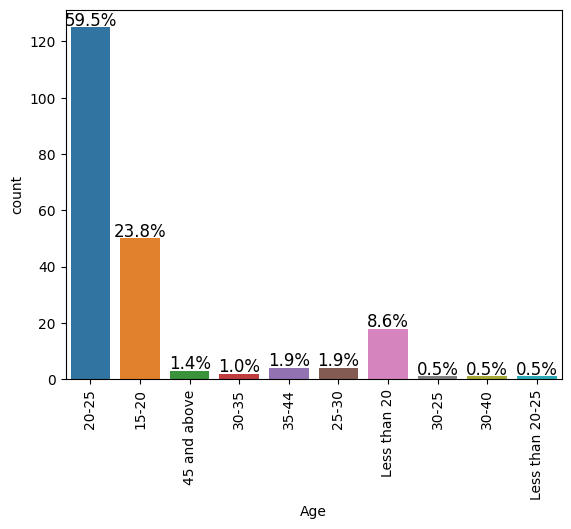

In [14]:
countplots(df,'Age', perc = True)

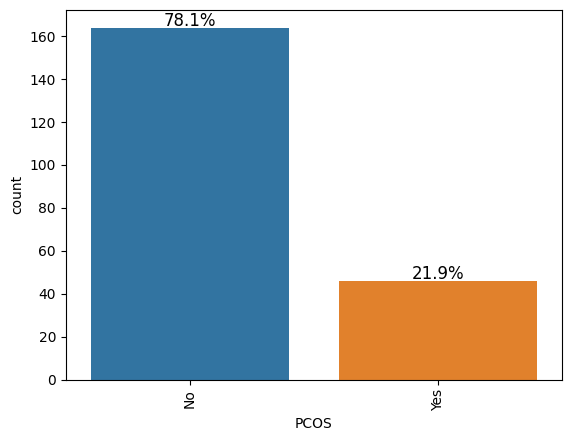

In [15]:
countplots(df,'PCOS', perc = True)

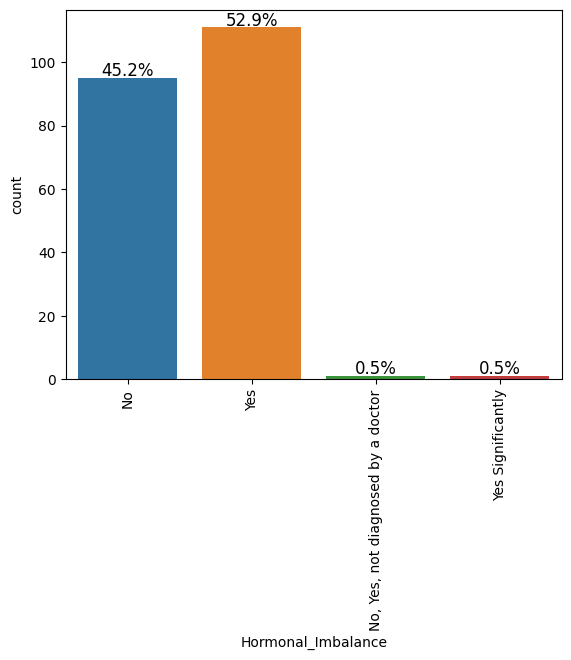

In [16]:
countplots(df,'Hormonal_Imbalance', perc = True)

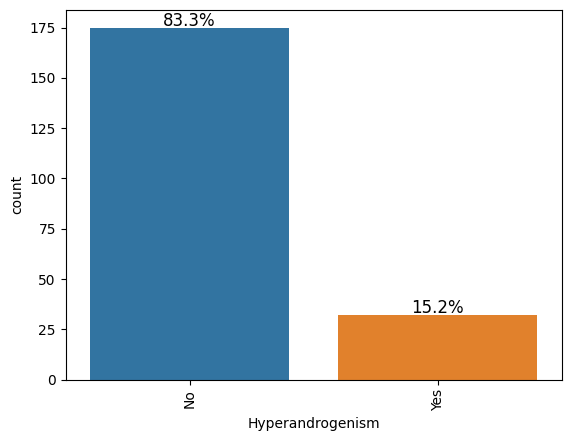

In [17]:
countplots(df,'Hyperandrogenism', perc = True)

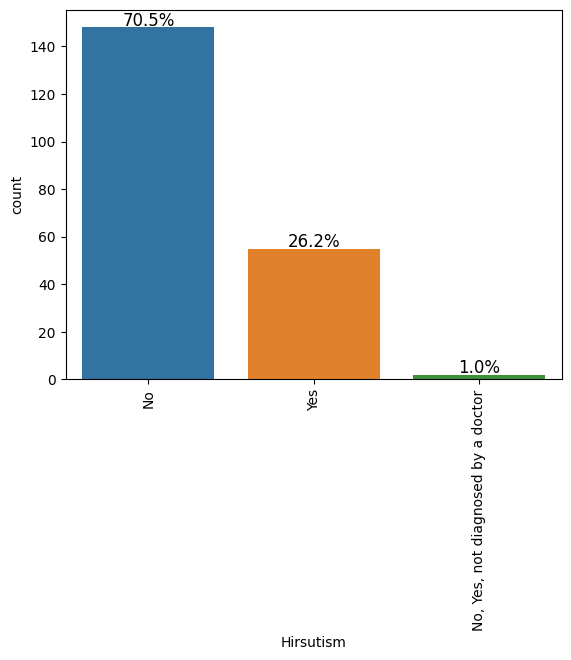

In [18]:
countplots(df,'Hirsutism', perc = True)

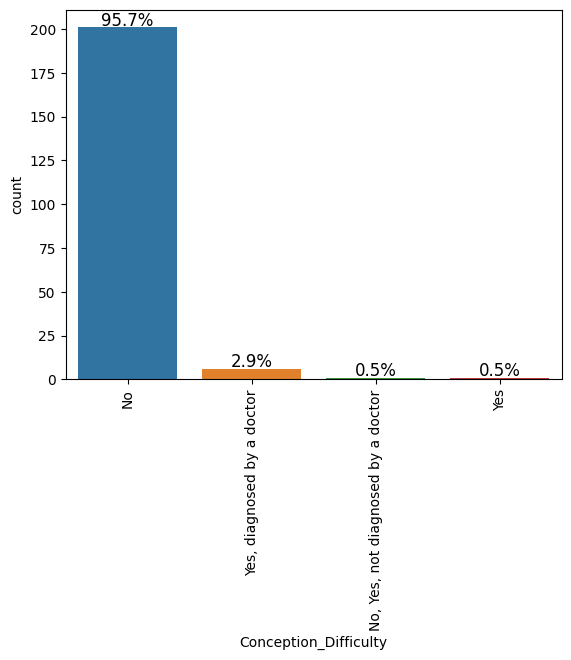

In [19]:
countplots(df,'Conception_Difficulty', perc = True)

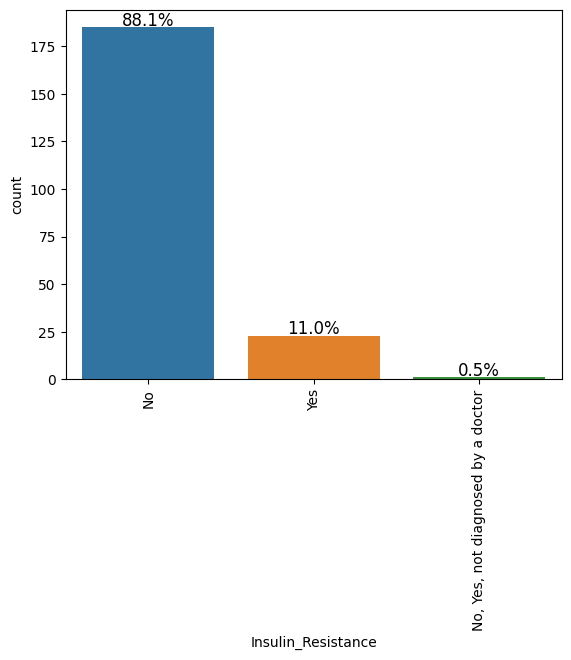

In [20]:
countplots(df,'Insulin_Resistance', perc = True)

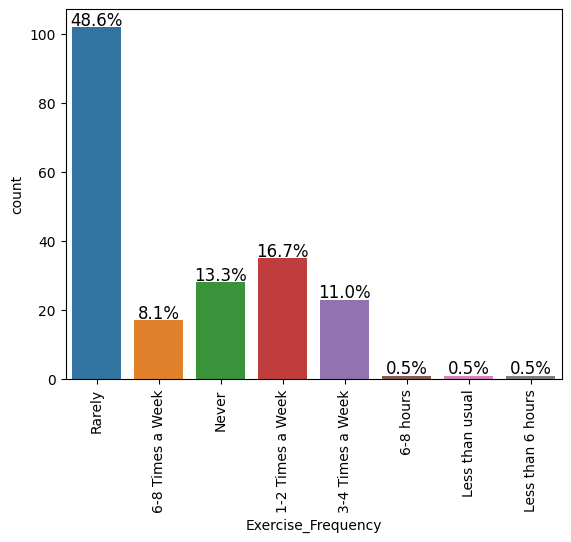

In [21]:
countplots(df,'Exercise_Frequency', perc = True)

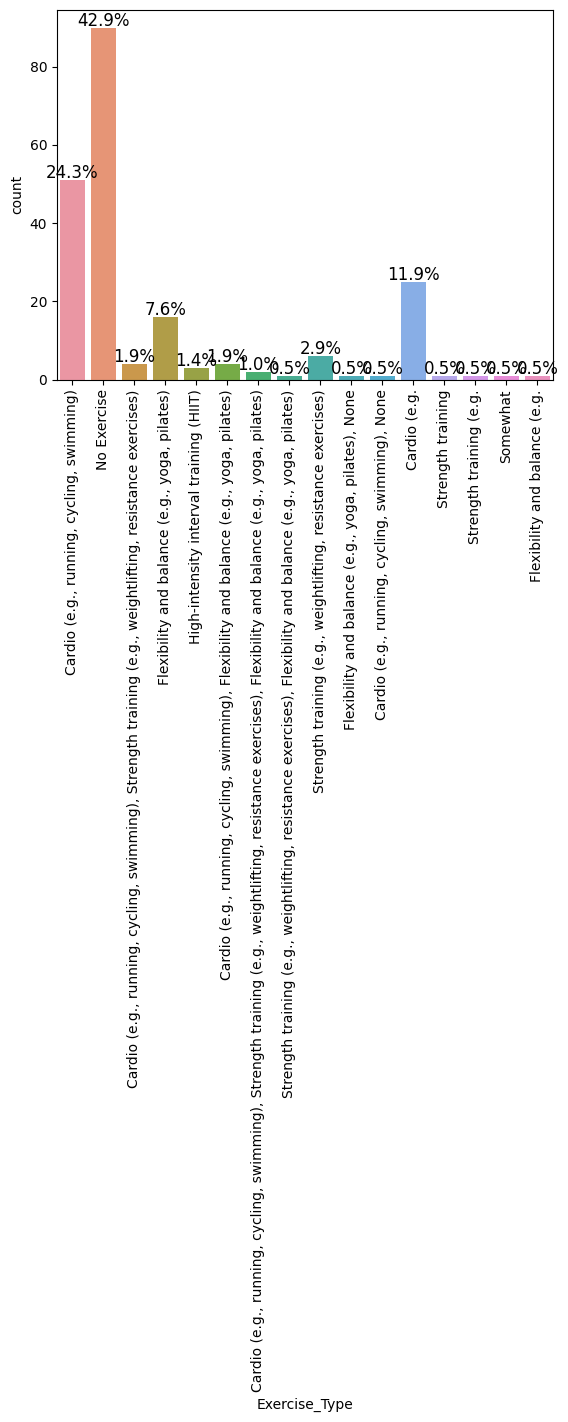

In [22]:
countplots(df,'Exercise_Type', perc = True)

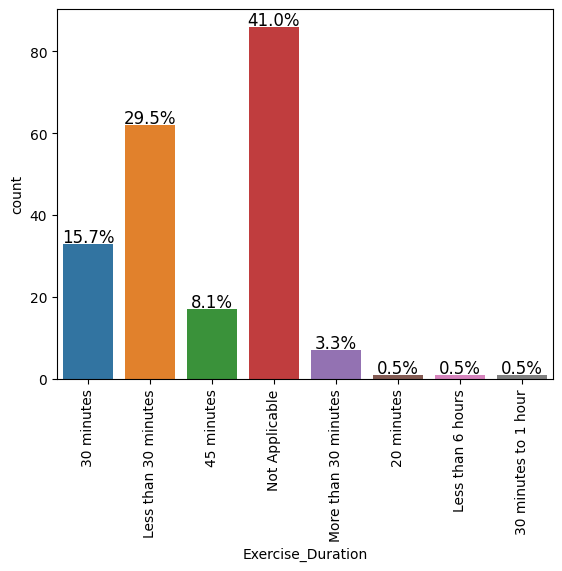

In [23]:
countplots(df,'Exercise_Duration', perc = True)

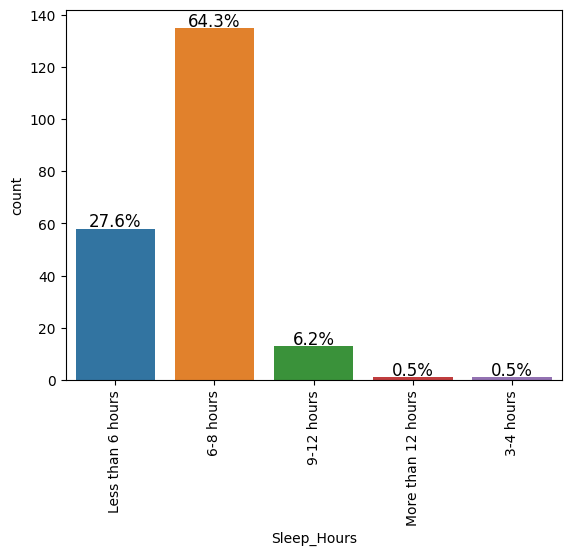

In [24]:
countplots(df,'Sleep_Hours', perc = True)

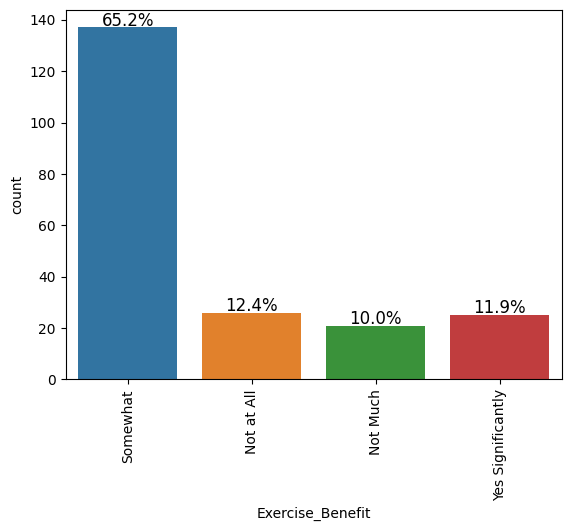

In [25]:
countplots(df,'Exercise_Benefit', perc = True)

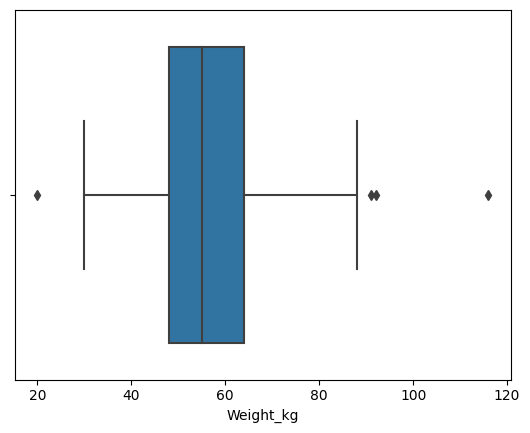

In [26]:
sns.boxplot(df, x = 'Weight_kg');

In [27]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

PCOS              No  Yes  All
Age                           
All              163   46  209
20-25             90   35  125
15-20             46    4   50
Less than 20      14    4   18
25-30              1    3    4
30-25              1    0    1
30-35              2    0    2
30-40              1    0    1
35-44              4    0    4
45 and above       3    0    3
Less than 20-25    1    0    1
------------------------------------------------------------------------------------------------------------------------


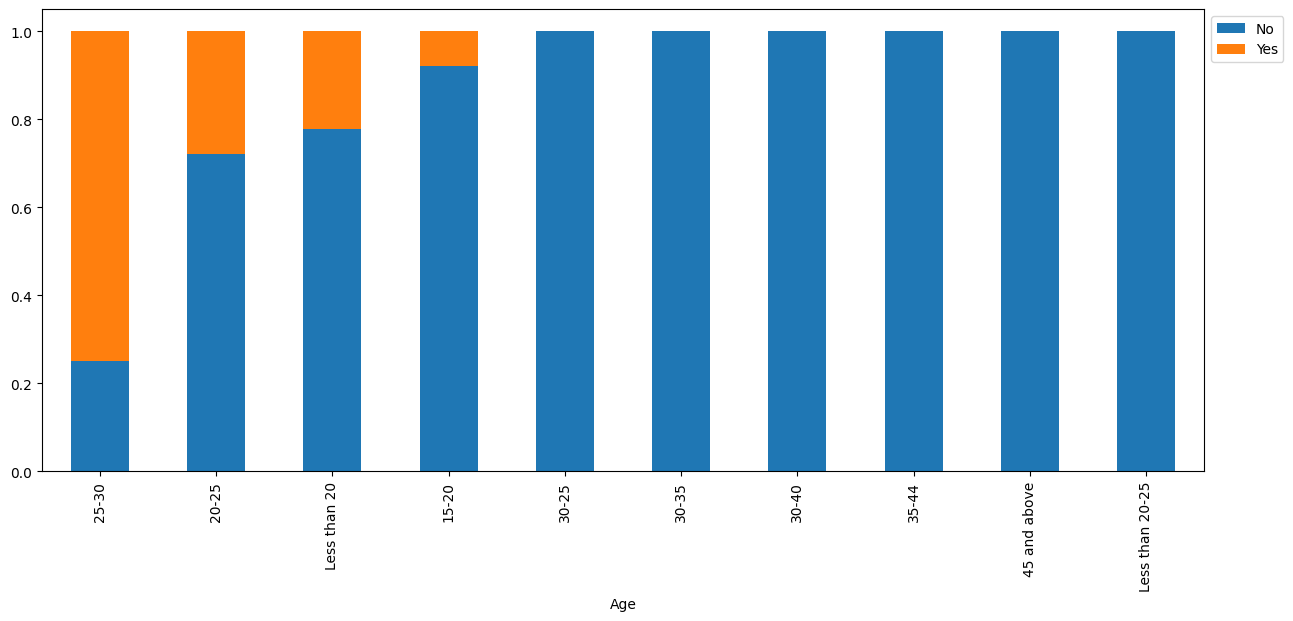

In [28]:
stacked_barplot(df,'Age' ,'PCOS')

PCOS                                 No  Yes  All
Hormonal_Imbalance                               
All                                 163   45  208
Yes                                  70   41  111
No                                   91    4   95
No, Yes, not diagnosed by a doctor    1    0    1
Yes Significantly                     1    0    1
------------------------------------------------------------------------------------------------------------------------


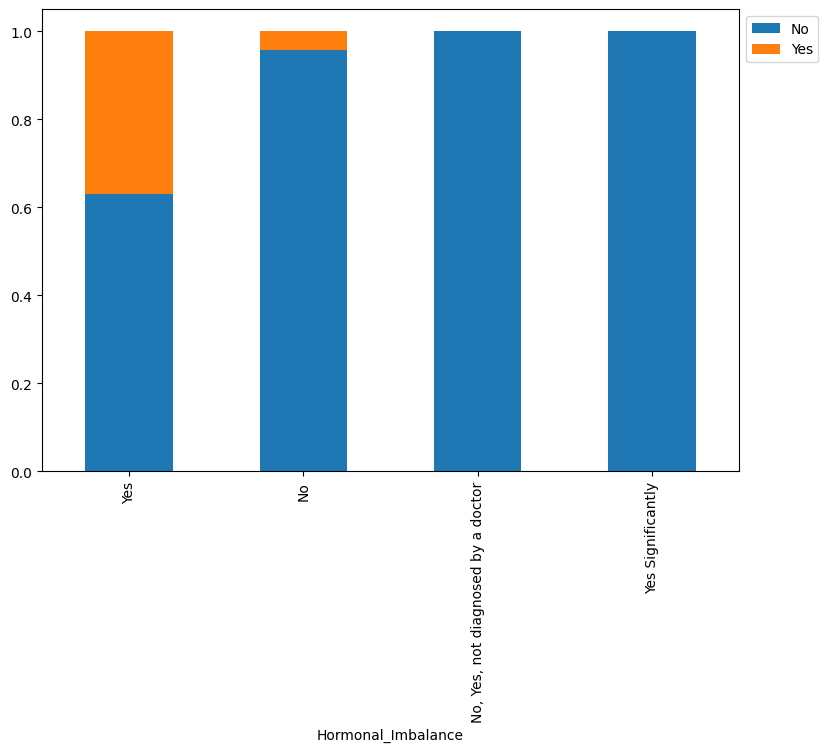

In [29]:
stacked_barplot(df,'Hormonal_Imbalance' ,'PCOS')

PCOS               No  Yes  All
Hyperandrogenism               
All               161   46  207
Yes                 8   24   32
No                153   22  175
------------------------------------------------------------------------------------------------------------------------


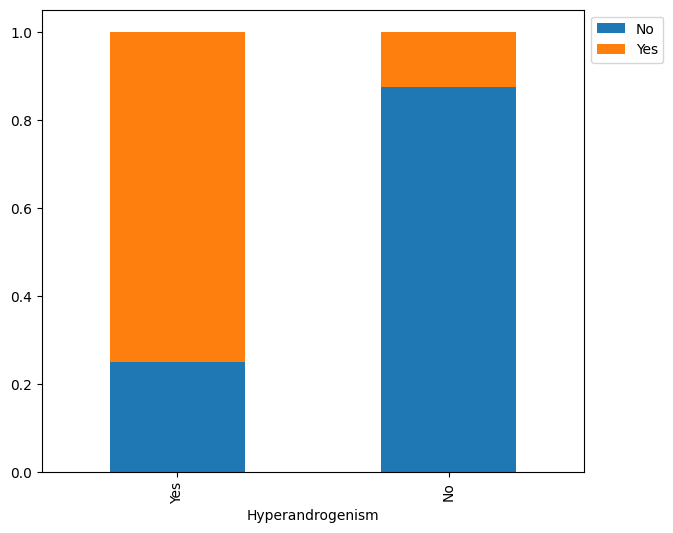

In [30]:
stacked_barplot(df,'Hyperandrogenism' ,'PCOS')

PCOS                                 No  Yes  All
Hirsutism                                        
All                                 161   44  205
Yes                                  29   26   55
No                                  131   17  148
No, Yes, not diagnosed by a doctor    1    1    2
------------------------------------------------------------------------------------------------------------------------


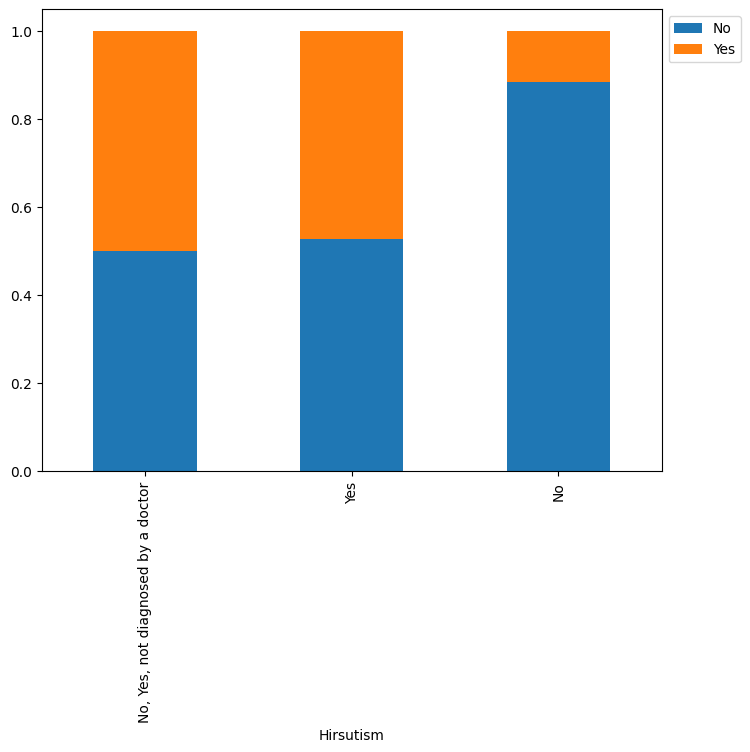

In [31]:
stacked_barplot(df,'Hirsutism' ,'PCOS')

PCOS                                 No  Yes  All
Conception_Difficulty                            
All                                 163   46  209
No                                  161   40  201
Yes, diagnosed by a doctor            0    6    6
No, Yes, not diagnosed by a doctor    1    0    1
Yes                                   1    0    1
------------------------------------------------------------------------------------------------------------------------


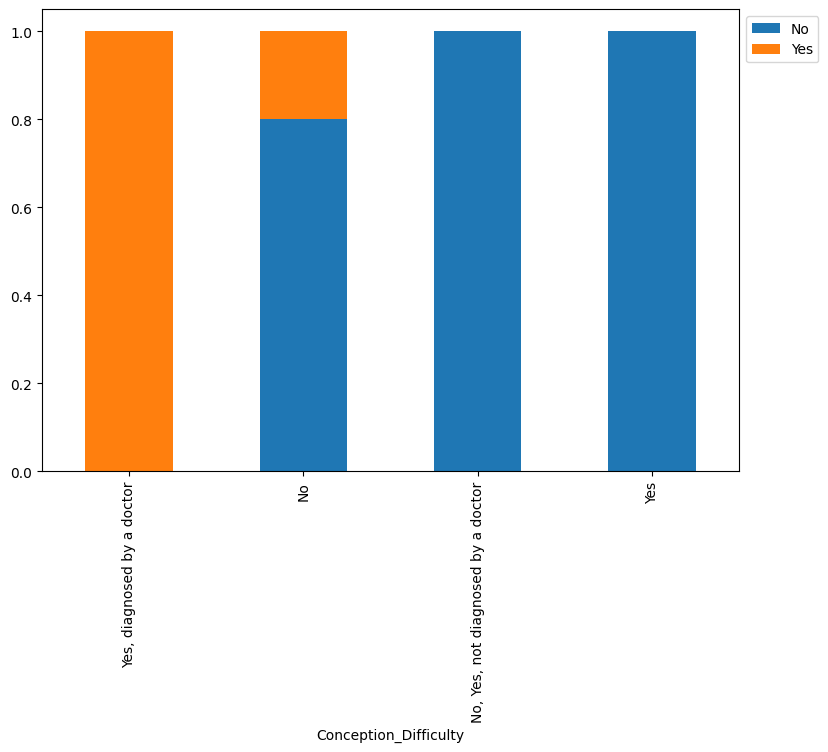

In [32]:
stacked_barplot(df,'Conception_Difficulty' ,'PCOS')

PCOS                                 No  Yes  All
Insulin_Resistance                               
All                                 163   46  209
No                                  156   29  185
Yes                                   6   17   23
No, Yes, not diagnosed by a doctor    1    0    1
------------------------------------------------------------------------------------------------------------------------


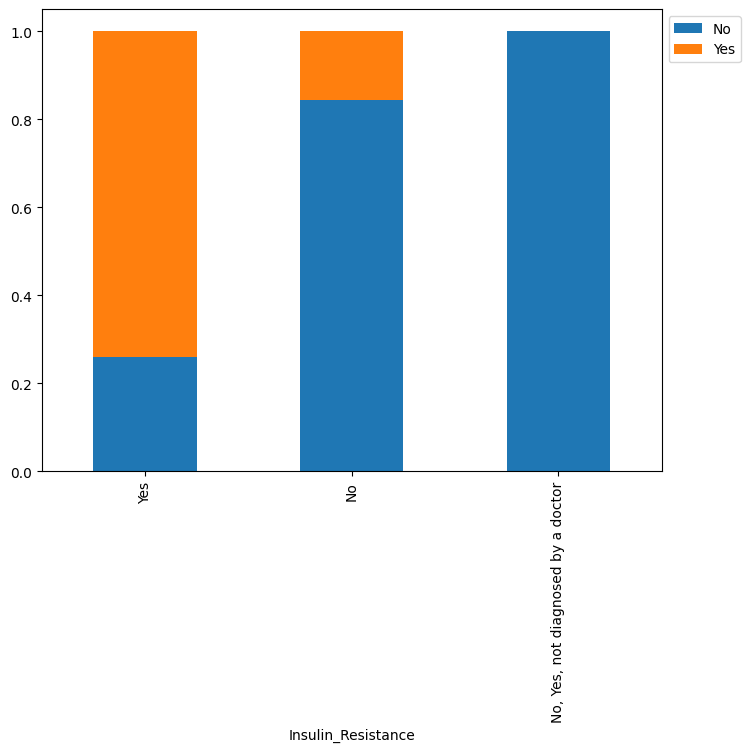

In [33]:
stacked_barplot(df,'Insulin_Resistance' ,'PCOS')

PCOS                 No  Yes  All
Exercise_Frequency               
All                 162   46  208
Rarely               79   23  102
Never                20    8   28
3-4 Times a Week     16    7   23
1-2 Times a Week     30    5   35
6-8 Times a Week     15    2   17
Less than 6 hours     0    1    1
6-8 hours             1    0    1
Less than usual       1    0    1
------------------------------------------------------------------------------------------------------------------------


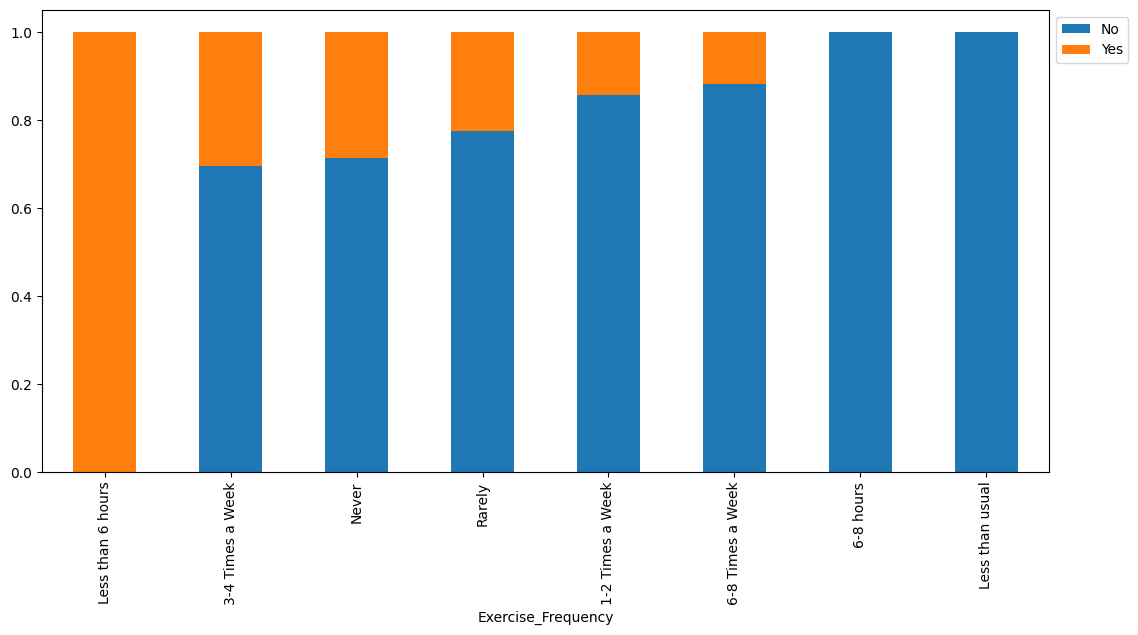

In [34]:
stacked_barplot(df,'Exercise_Frequency' ,'PCOS')

PCOS                                                 No  Yes  All
Exercise_Type                                                    
All                                                 162   46  208
No Exercise                                          71   19   90
Cardio (e.g., running, cycling, swimming)            40   11   51
Cardio (e.g.                                         19    6   25
Flexibility and balance (e.g., yoga, pilates)        13    3   16
High-intensity interval training (HIIT)               1    2    3
Cardio (e.g., running, cycling, swimming), Stre...    3    1    4
Cardio (e.g., running, cycling, swimming), None       0    1    1
Cardio (e.g., running, cycling, swimming), Flex...    3    1    4
Strength training (e.g., weightlifting, resista...    5    1    6
Flexibility and balance (e.g., yoga, pilates), ...    0    1    1
Cardio (e.g., running, cycling, swimming), Stre...    2    0    2
Flexibility and balance (e.g.                         1    0    1
Somewhat  

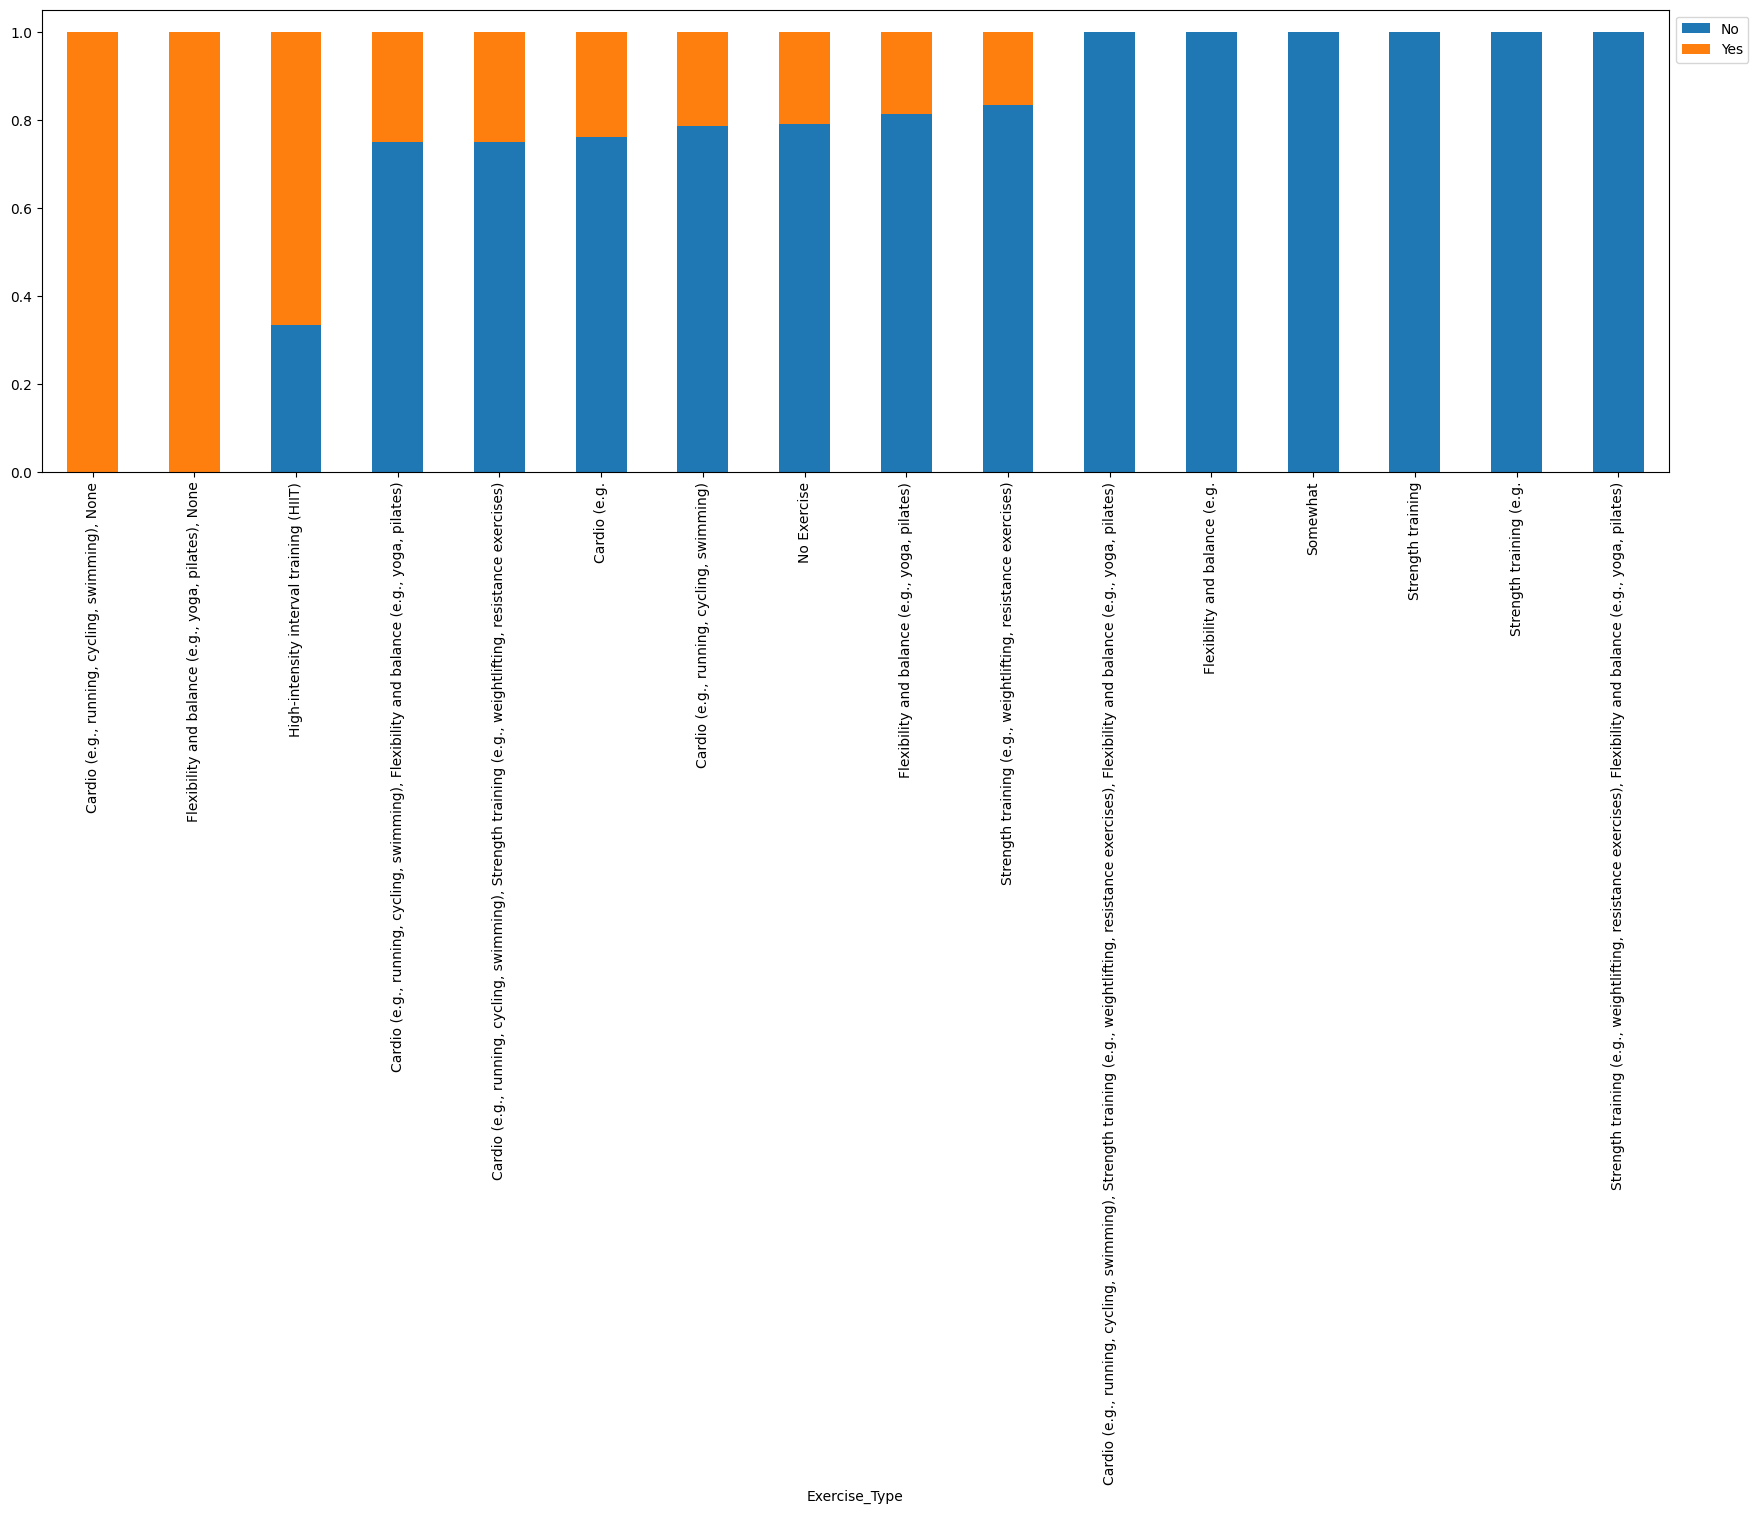

In [35]:
stacked_barplot(df,'Exercise_Type' ,'PCOS')

PCOS                   No  Yes  All
Exercise_Duration                  
All                   162   46  208
Not Applicable         67   19   86
Less than 30 minutes   48   14   62
30 minutes             27    6   33
45 minutes             13    4   17
More than 30 minutes    5    2    7
Less than 6 hours       0    1    1
20 minutes              1    0    1
30 minutes to 1 hour    1    0    1
------------------------------------------------------------------------------------------------------------------------


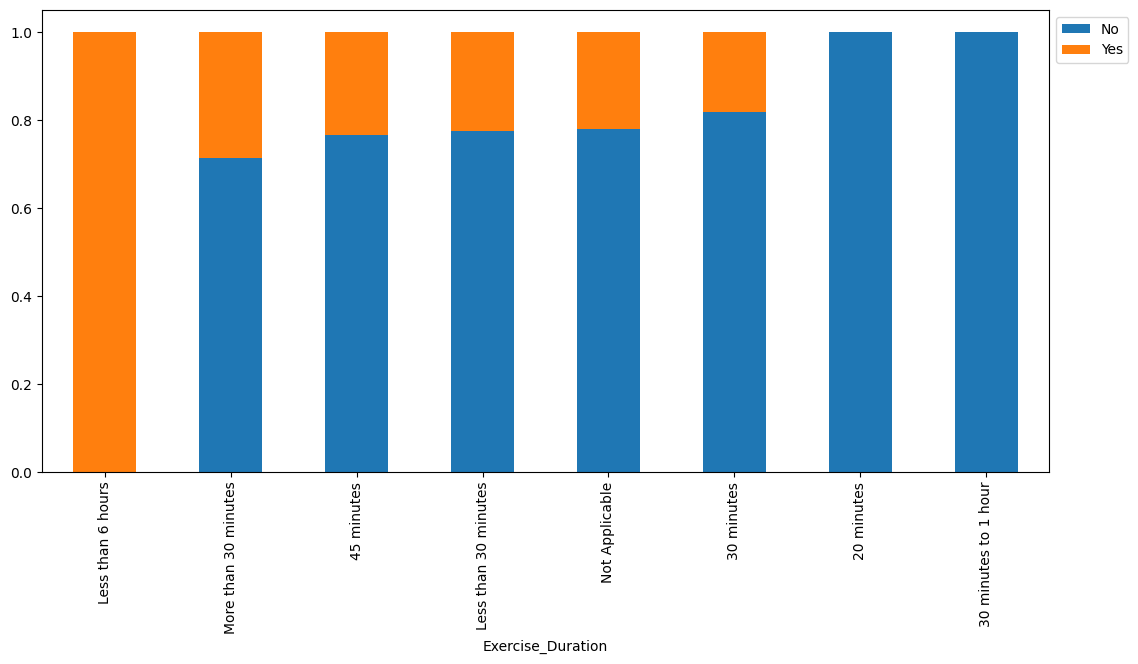

In [36]:
stacked_barplot(df,'Exercise_Duration' ,'PCOS')

PCOS                 No  Yes  All
Sleep_Hours                      
All                 162   46  208
6-8 hours           108   27  135
Less than 6 hours    42   16   58
9-12 hours           10    3   13
3-4 hours             1    0    1
More than 12 hours    1    0    1
------------------------------------------------------------------------------------------------------------------------


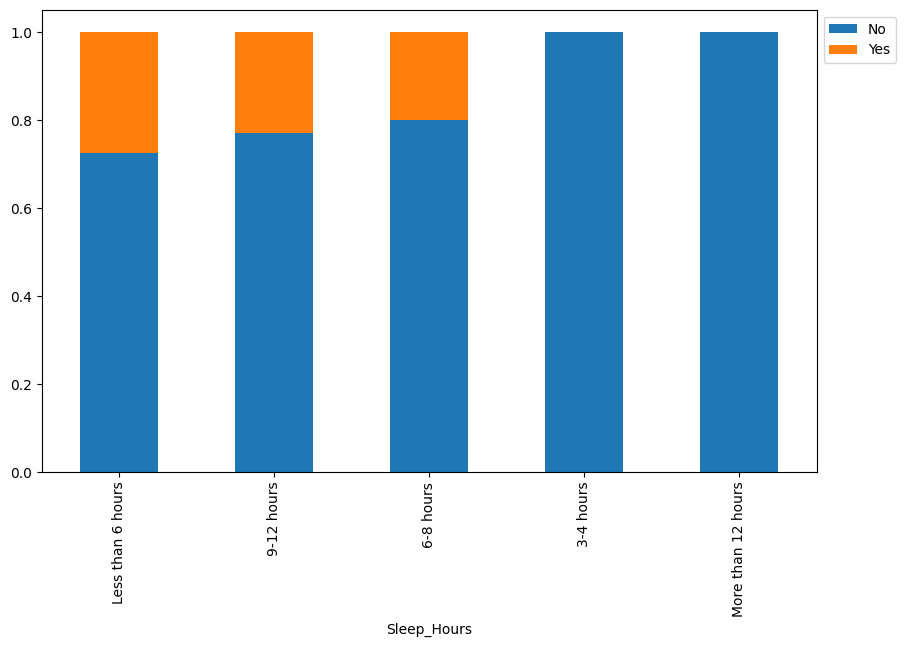

In [37]:
stacked_barplot(df,'Sleep_Hours' ,'PCOS')

PCOS                No  Yes  All
Exercise_Benefit                
All                163   46  209
Somewhat           110   27  137
Not Much            13    8   21
Yes Significantly   19    6   25
Not at All          21    5   26
------------------------------------------------------------------------------------------------------------------------


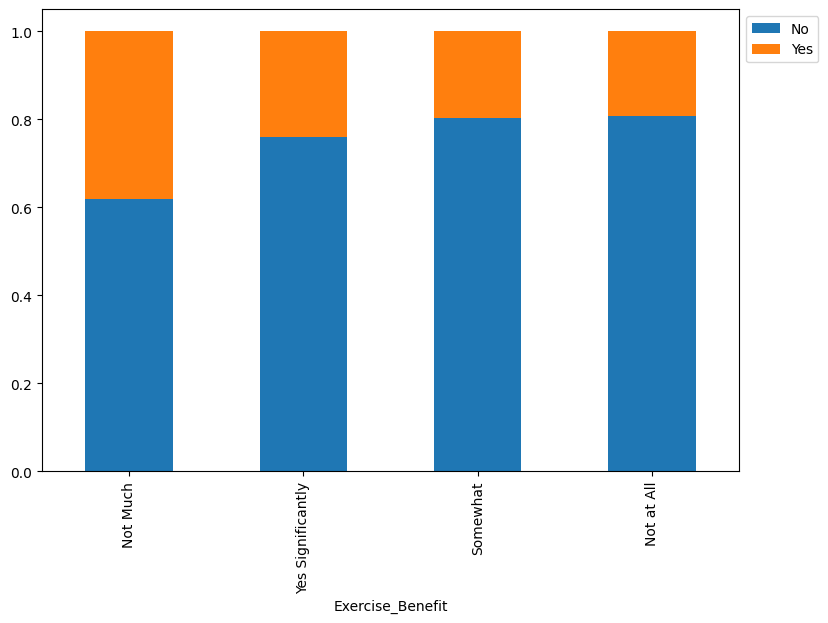

In [38]:
stacked_barplot(df,'Exercise_Benefit' ,'PCOS')

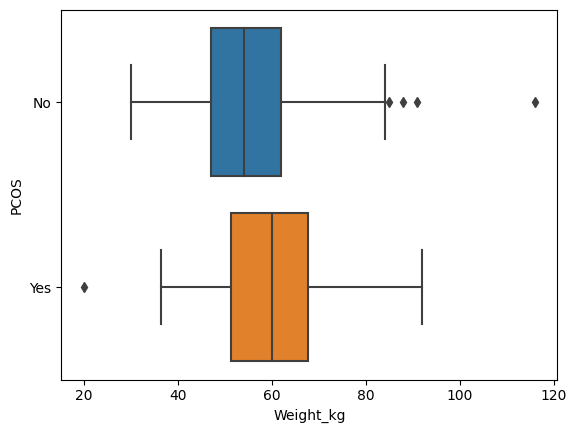

In [39]:
sns.boxplot(df, x = 'Weight_kg', y = "PCOS");

In [40]:
train_id = df['ID']
test_id = test['ID']

In [41]:
X = df.drop(['PCOS','ID'], axis=1)
y = df['PCOS']
test_data = test.drop(columns=["ID"],axis=1)

In [42]:
test_data

,Age,Weight_kg,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,20-25,54.0,No,No,No,No,No,Rarely,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
1,20-25,65.0,Yes,No,No,No,No,3-4 Times a Week,No Exercise,Not Applicable,6-8 hours,Somewhat
2,20-25,64.0,Yes,No,No,No,No,6-8 Times a Week,Cardio (e.g.,Not Applicable,6-8 hours,Somewhat
3,Less than 20,57.0,Yes,No,Yes,No,Yes,Rarely,No Exercise,6-8 hours,6-8 hours,Somewhat
4,Less than 20,6.0,Yes,No,Yes,No,No,Rarely,Cardio (e.g.,30 minutes,6-8 hours,Somewhat
...,...,...,...,...,...,...,...,...,...,...,...,...
140,20-25,52.0,Yes,No,No,No,No,Rarely,Cardio (e.g.,Less than 30 minutes,6-8 hours,Somewhat
141,20-25,67.0,No,No,No,No,No,Rarely,Strength training (e.g.,Less than 30 minutes,6-8 hours,Not at All
142,20-25,55.0,Yes,Yes,Yes,Yes,No,Rarely,Cardio (e.g.,Less than 20 minutes,6-8 hours,Yes Significantly
143,Less than 20,49.0,No,No,Yes,No,No,1/2 Times a Week,Cardio (e.g.,Less than 30 minutes,6-8 hours,Not Much


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    209 non-null    object 
 1   Weight_kg              208 non-null    float64
 2   Hormonal_Imbalance     208 non-null    object 
 3   Hyperandrogenism       207 non-null    object 
 4   Hirsutism              205 non-null    object 
 5   Conception_Difficulty  209 non-null    object 
 6   Insulin_Resistance     209 non-null    object 
 7   Exercise_Frequency     208 non-null    object 
 8   Exercise_Type          208 non-null    object 
 9   Exercise_Duration      208 non-null    object 
 10  Sleep_Hours            208 non-null    object 
 11  Exercise_Benefit       209 non-null    object 
dtypes: float64(1), object(11)
memory usage: 19.8+ KB


In [44]:
y = y.map({'Yes': 1, 'No': 0})

In [45]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#X.columns = X.columns.str.strip().str.lower()

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))     
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

X_train = preprocessor.fit_transform(X)
X_test = preprocessor.transform(test_data)

Numerical Features: ['Weight_kg']
Categorical Features: ['Age', 'Hormonal_Imbalance', 'Hyperandrogenism', 'Hirsutism', 'Conception_Difficulty', 'Insulin_Resistance', 'Exercise_Frequency', 'Exercise_Type', 'Exercise_Duration', 'Sleep_Hours', 'Exercise_Benefit']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y)

In [47]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_balanced,y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
predictions =  xgb.predict_proba(X_test)[:, 1]
output = pd.DataFrame({'ID': test.ID, 'PCOS': predictions})
output.to_csv('submission1.csv', index=False)

In [49]:
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train_balanced,y_train_balanced)

RandomForestClassifier(random_state=1)

In [50]:
predictions =  rf_estimator.predict_proba(X_test)[:, 1]
output = pd.DataFrame({'ID': test.ID, 'PCOS': predictions})
output.to_csv('submission2.csv', index=False)

In [51]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train_balanced,y_train_balanced)

GradientBoostingClassifier(random_state=1)

In [52]:
predictions =  gb_classifier.predict_proba(X_test)[:, 1]
output = pd.DataFrame({'ID': test.ID, 'PCOS': predictions})
output.to_csv('submission3.csv', index=False)

In [53]:
from catboost import CatBoostClassifier
cat_boost = CatBoostClassifier(random_state=1, verbose=200)
cat_boost.fit(X_train_balanced,y_train_balanced)


Learning rate set to 0.0064
0:	learn: 0.6869843	total: 56.6ms	remaining: 56.5s
200:	learn: 0.2747141	total: 357ms	remaining: 1.42s
400:	learn: 0.1849343	total: 673ms	remaining: 1s
600:	learn: 0.1398085	total: 990ms	remaining: 657ms
800:	learn: 0.1118082	total: 1.3s	remaining: 323ms
999:	learn: 0.0929987	total: 1.6s	remaining: 0us


In [54]:
predictions =  cat_boost.predict_proba(X_test)[:, 1]
output = pd.DataFrame({'ID': test.ID, 'PCOS': predictions})
output.to_csv('submission4.csv', index=False)

In [55]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

model1 = GradientBoostingClassifier(random_state=1)
model2 = XGBClassifier(random_state=1)
model3 = CatBoostClassifier(random_state=1, verbose=0)

ensemble_model = VotingClassifier(estimators=[('gbc', model1), ('xgb', model2), ('catboost', model3)], voting='soft')
ensemble_model.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(random_state=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7b46bc4a7340>)],
                 voting='soft')

In [56]:
predictions =  ensemble_model.predict_proba(X_test)[:, 1]
output = pd.DataFrame({'ID': test.ID, 'PCOS': predictions})
output.to_csv('submission5.csv', index=False)

In [57]:
from IPython.display import FileLink

# Path to your file
file_path = 'submission4.csv'

# Generate and display the download link
FileLink(file_path)

/kaggle/working/submission4.csv